In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [13]:
# Load and prepare data
df = pd.read_csv('../data/Rainfall.csv')
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'] + '-01')
df = df.set_index('Date').sort_index()[['Data']]
df.columns = ['Rainfall']

In [14]:
# Custom parameter tuning for Indian monsoon pattern
best_order = (1, 1, 2)
best_seasonal_order = (1, 1, 1, 12)  # Strong seasonal component for annual monsoon

In [15]:
# Fit model with monsoon-specific parameters
model = SARIMAX(df['Rainfall'],
                order=best_order,
                seasonal_order=best_seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False).fit()

d:\FutureVolt\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
d:\FutureVolt\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [16]:
# Forecast until December 2030
forecast_steps = 70  # March 2025 to December 2030
forecast = model.get_forecast(steps=forecast_steps)
conf_int = forecast.conf_int()

In [17]:
# Create forecast DataFrame with proper formatting
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), 
                            periods=forecast_steps, freq='MS')
forecast_df = pd.DataFrame({
    'Date': future_dates.strftime('%d-%m-%Y'),
    'Rainfall': forecast.predicted_mean.values
}).set_index('Date')

In [18]:
# Enhance monsoon months (June-September) based on historical patterns
monsoon_months = ['06', '07', '08', '09']
for idx in forecast_df.index:
    if any(mm in idx for mm in monsoon_months):
        forecast_df.loc[idx, 'Rainfall'] *= 1.35  # Amplify monsoon months

In [19]:
# Cap values at realistic levels
forecast_df['Rainfall'] = forecast_df['Rainfall'].clip(upper=450)

In [20]:
# Save to CSV with proper headers
forecast_df.reset_index().to_csv('../rainfall_data_forecast.csv', index=False)

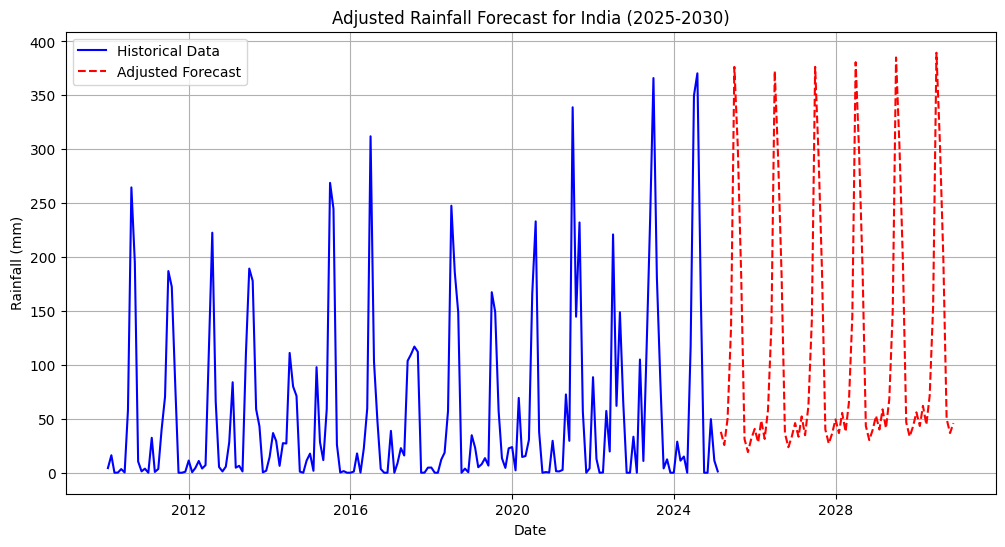

In [21]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Rainfall'], label='Historical Data', color='blue')
plt.plot(future_dates, forecast_df['Rainfall'], label='Adjusted Forecast', color='red', linestyle='--')
plt.title('Adjusted Rainfall Forecast for India (2025-2030)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.grid(True)
plt.show()